# 1 Topics Analysis & Trend

In [2]:
import pandas as pd
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [4]:
# Load data
data = pd.read_excel("FTSE100 Data_ESG.xlsx", sheet_name='uk companies esg score')

In [6]:
# Restructure data to long format
data_long = pd.melt(
    data,
    id_vars = ["Company Name"],
    value_vars = [2023,2022,2021,2020],
    var_name = "Year",
    value_name = "Text"
)

In [8]:
# Remove lines without text
data_long = data_long.dropna(subset = ["Text"]).reset_index(drop=True)

In [10]:
# Topic Modeling with BERTopic
vectorizer_model = CountVectorizer(stop_words="english")
cluster_model = KMeans(n_clusters=12)
topic_model = BERTopic(hdbscan_model=cluster_model, vectorizer_model = vectorizer_model, verbose = True)

In [12]:
# Extract report text and year
texts = data_long["Text"].tolist()
years = data_long["Year"].tolist()

In [14]:
# Fit the model and get topics
topics, probs = topic_model.fit_transform(texts)

2025-01-15 12:36:01,812 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-01-15 12:36:06,329 - BERTopic - Embedding - Completed ✓
2025-01-15 12:36:06,330 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-15 12:36:08,630 - BERTopic - Dimensionality - Completed ✓
2025-01-15 12:36:08,630 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-01-15 12:36:08,881 - BERTopic - Cluster - Completed ✓
2025-01-15 12:36:08,885 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-15 12:36:08,953 - BERTopic - Representation - Completed ✓


In [16]:
# Add results to the data table
data_long["Topic"] = topics

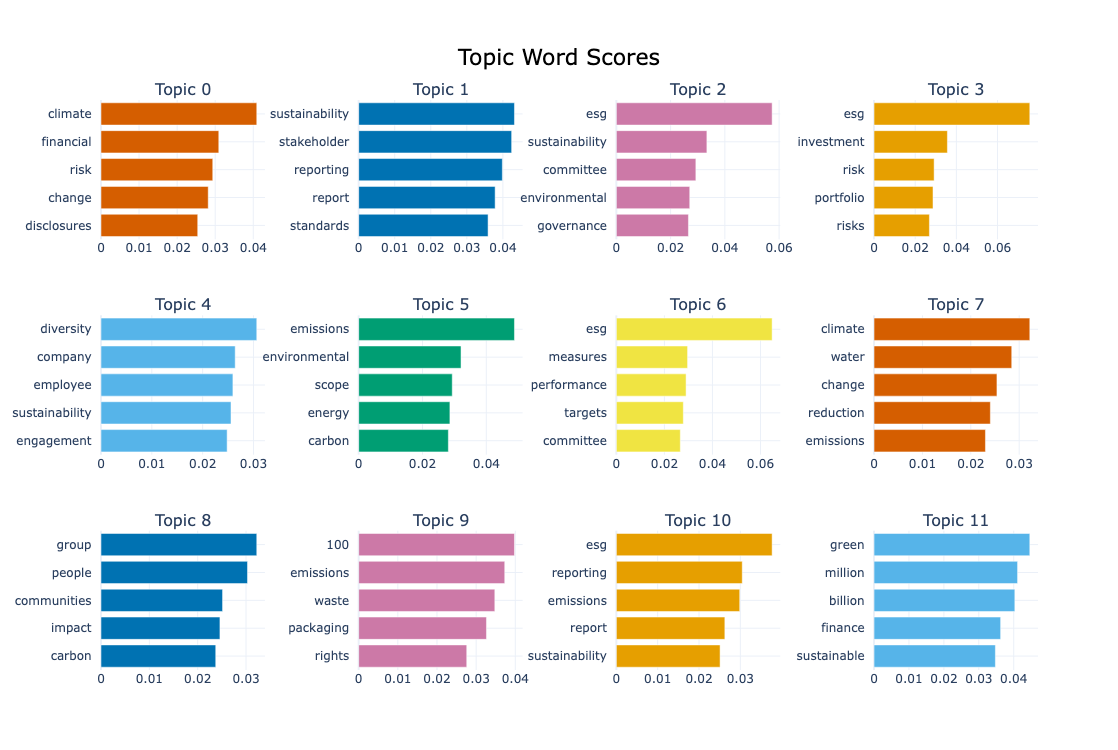

In [18]:
# Visualization of topic changes over time
fig = topic_model.visualize_barchart(top_n_topics=12, custom_labels=True)
fig.show()

4it [00:00, 36.88it/s]


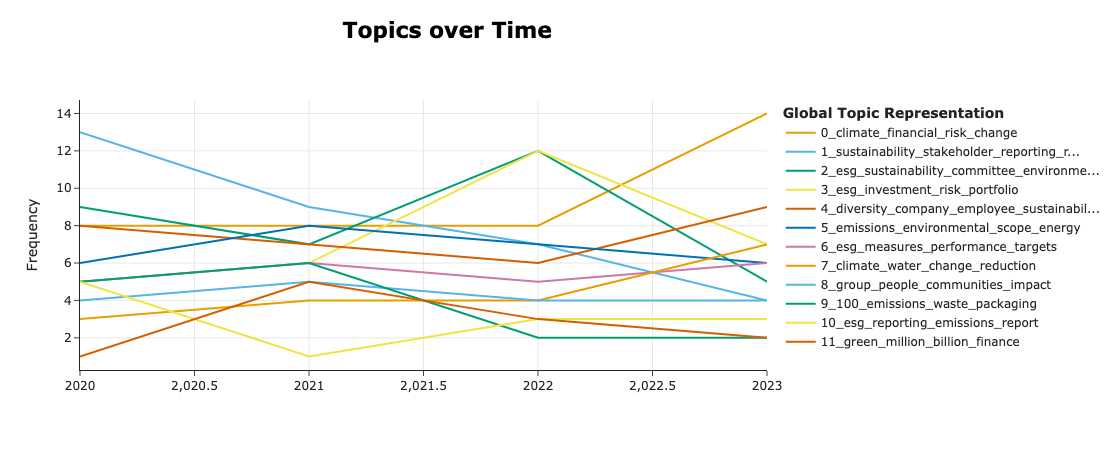

In [20]:
topics_over_time = topic_model.topics_over_time(texts, years)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=12)

# 2 Network Construction

In [23]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2-1 Company-Company

In [26]:
# Get the association between company and topic
company_topic_matrix = pd.crosstab(data_long["Company Name"], data_long["Topic"])

# Calculate the company-company simlarity matrix
company_similarity = np.dot(company_topic_matrix, company_topic_matrix.T)

#Create a company-company net work diagram
G_company = nx.Graph()

In [28]:
# Add company node
for company in company_topic_matrix.index:
    G_company.add_node(company)

#Add edges between companies
for i, company1 in enumerate(company_topic_matrix.index):
    for j, company2 in enumerate(company_topic_matrix.index):
        if i<j:
            similarity_score = company_similarity[i, j]
            if similarity_score > 4:
                G_company.add_edge(company1, company2, weight=similarity_score)

<function matplotlib.pyplot.show(close=None, block=None)>

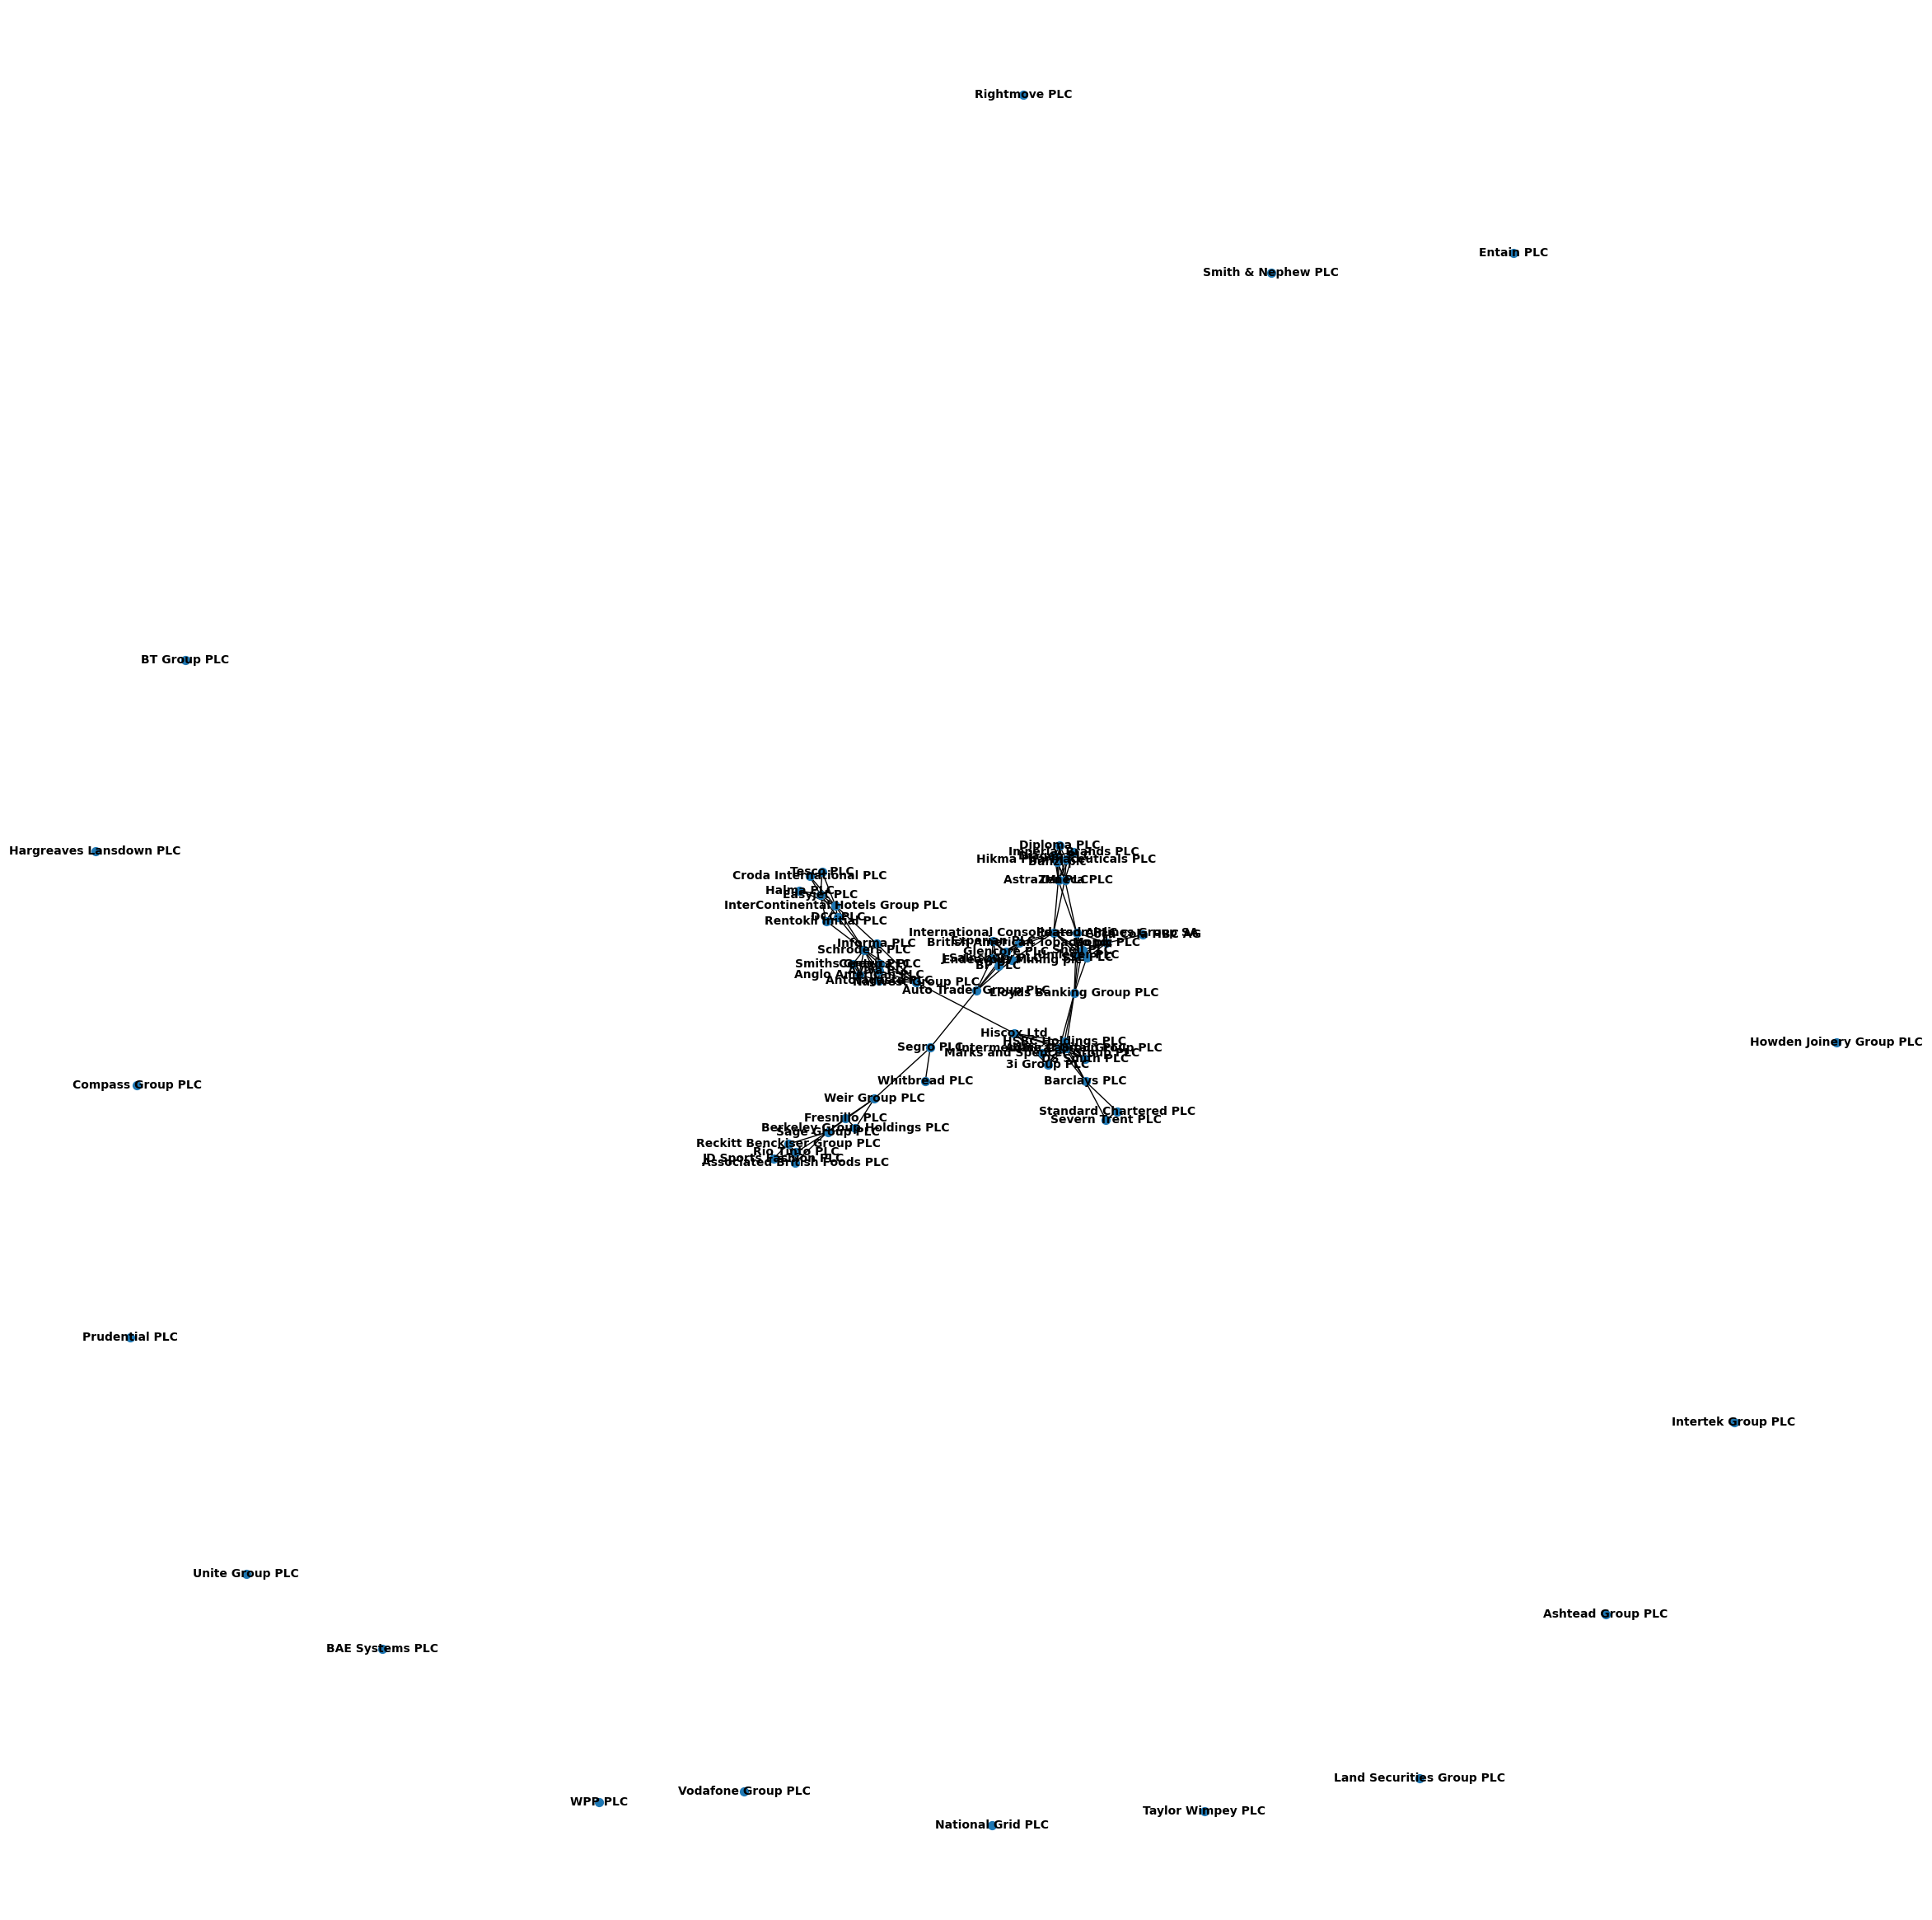

In [30]:
# Visualize company-company Networks
fig, ax = plt.subplots(figsize=(30, 30))
pos = nx.spring_layout(G_company)
nx.draw(G_company, pos, with_labels=True, node_size=50, font_size=10, font_weight='bold', ax=ax)
plt.show

## 2-2 Topic-Topic

In [33]:
# Create Topic-Comapny Matrix
topic_company_matrix = pd.crosstab(data_long["Topic"], data_long["Company Name"])

# Calculate the topic-topic similarity matrix
topic_similarity = np.dot(topic_company_matrix, topic_company_matrix.T)

# Create a Topic-Topic Network Diagram
G_topic = nx.Graph()

In [35]:
# Add a topic node
for topic in topic_company_matrix.index:
    G_topic.add_node(topic)

# Add edges between topics
for i, topic1 in enumerate(topic_company_matrix.index):
    for j, topic2 in enumerate(topic_company_matrix.index):
        if i < j:
            similarity_score = topic_similarity[i, j]
            if similarity_score > 4:
                G_topic.add_edge(topic1, topic2, weight=similarity_score)

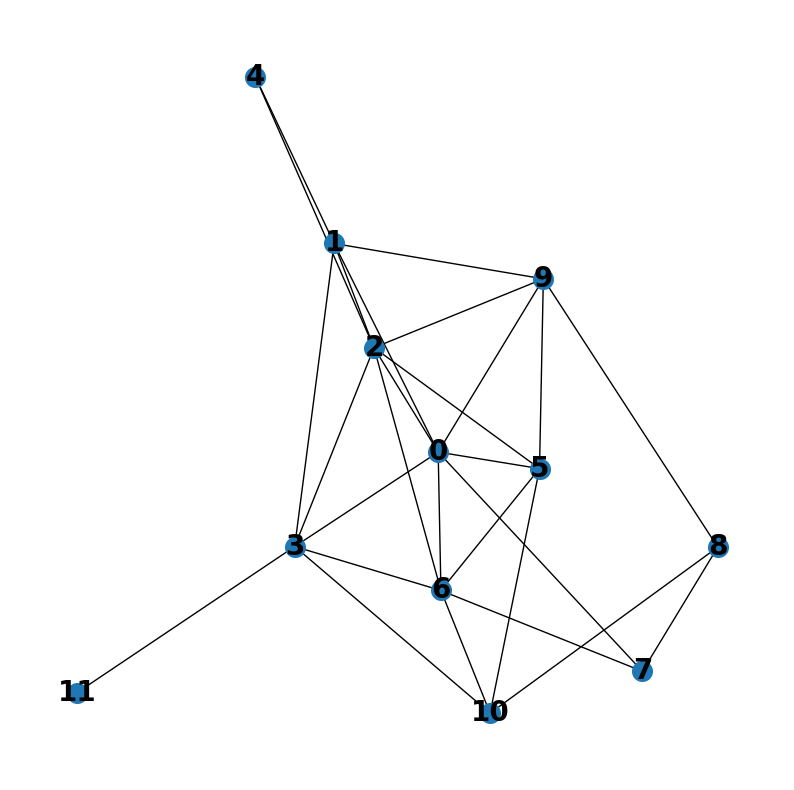

In [37]:
# Visualizing Topic-Topic Networks
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G_topic)
nx.draw(G_topic, pos, with_labels=True, node_size=200, font_size=20, font_weight='bold', ax=ax)
plt.show()

# 3 Clustering

In [40]:
from community import community_louvain

In [42]:
# Louvain algorithm for firm-to-firm clustering
partition_company = community_louvain.best_partition(G_company)

# Add company clustering results to the graph
for company, community in partition_company.items():
    G_company.nodes[company]["community"] = community

/var/folders/6w/t45c6gh10pv491wlmt_k_plm0000gn/T/ipykernel_54215/1070121307.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



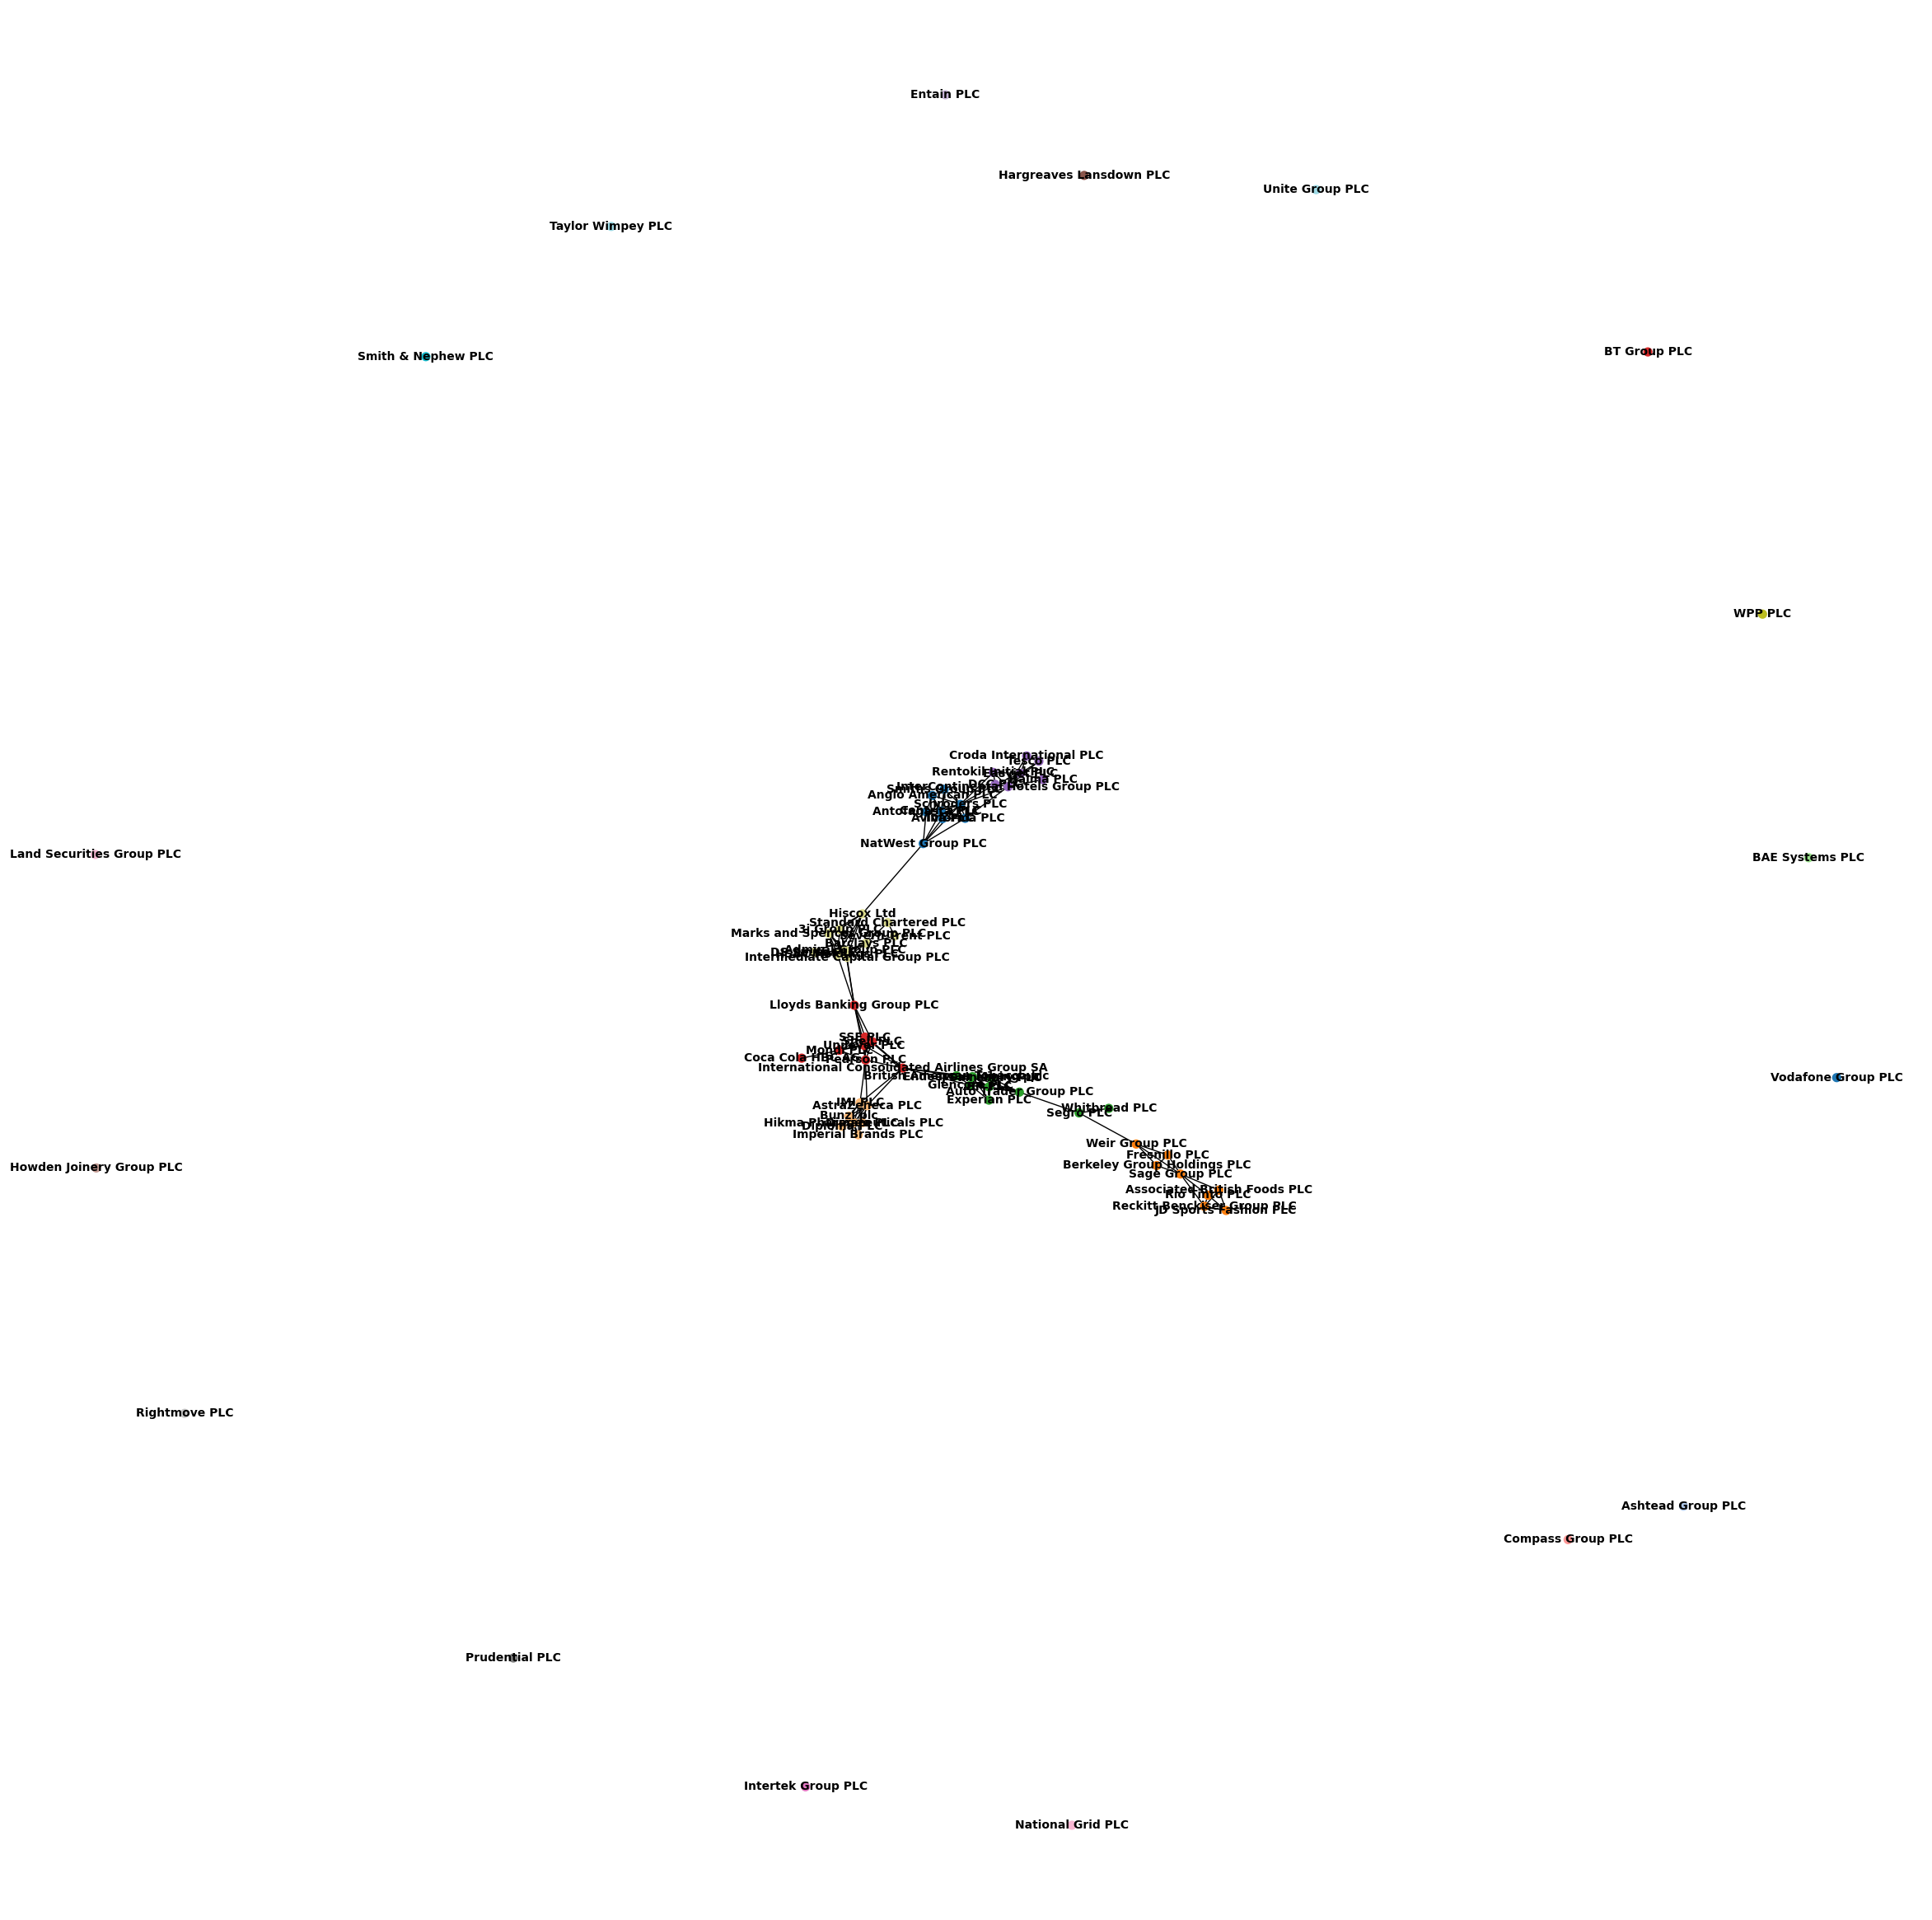

In [44]:
# Visualize clustered company-company networks
fix, ax = plt.subplots(figsize=(30, 30))
pos = nx.spring_layout(G_company)
cmap = plt.cm.get_cmap("tab20", len(set(partition_company.values())))
nx.draw(G_company, pos, with_labels=True, node_size=50, font_size=10, font_weight='bold',
        node_color=[cmap(partition_company[company]) for company in G_company.nodes()],ax=ax)
plt.show()

In [46]:
# Louvain algorithm for topic-topic clustering
partition_topic = community_louvain.best_partition(G_topic)

# Add topic clustering results to the graph
for topic, community in partition_topic.items():
    G_topic.nodes[topic]["community"] = community

/var/folders/6w/t45c6gh10pv491wlmt_k_plm0000gn/T/ipykernel_54215/3946607610.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



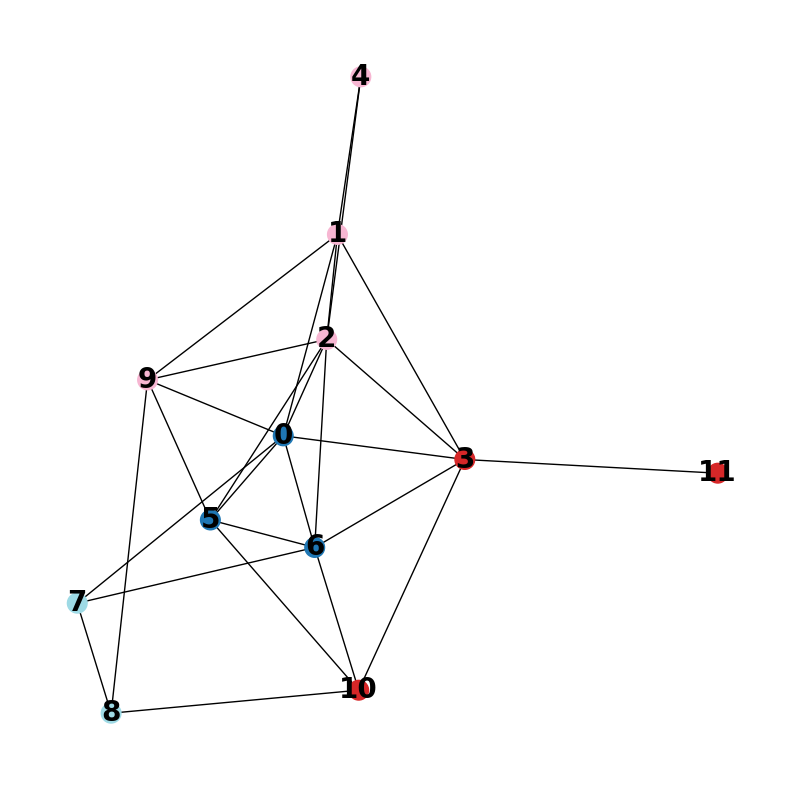

In [52]:
# Visualizing the clustered topic-topic network
fix, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G_topic)
cmap = plt.cm.get_cmap("tab20", len(set(partition_topic.values())))
nx.draw(G_topic, pos, with_labels=True, node_size=200, font_size=20, font_weight='bold',
        node_color=[cmap(partition_topic[topic]) for topic in G_topic.nodes()],ax=ax)
plt.show()

# 4 Find Out the most Influential Indicator with Random Forest

## 4-1 Scores -> Numbers

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [58]:
# Load data
df = pd.read_excel('FTSE100 Data_ESG.xlsx')

In [60]:
# Mapping ESG grades to numerical values
grade_mapping = {
    "D-": 1, "D": 2, "D+": 3, 
    "C-": 4, "C": 5, "C+": 6, 
    "B-": 7, "B": 8, "B+": 9, 
    "A-": 10, "A": 11, "A+": 12
}

In [62]:
rating_columns = [
    "ESG Score Grade\n(FY0)", "ESG Combined Score Grade\n(FY0)", 
    "Environmental Pillar Score Grade\n(FY0)", "Social Pillar Score Grade\n(FY0)", 
    "Governance Pillar Score Grade\n(FY0)"
]


for col in rating_columns:
    df[col] = df[col].map(grade_mapping)

In [64]:
# Check and fill missing numeric values
numeric_median = df.select_dtypes(include=["number"]).median()
df.fillna(numeric_median, inplace=True)

In [66]:
# Feature Selection
#features = [
#    "ESG Score Grade\n(FY0)", "ESG Combined Score Grade\n(FY0)", 
#    "Environmental Pillar Score Grade\n(FY0)", "Social Pillar Score Grade\n(FY0)", 
#    "Governance Pillar Score Grade\n(FY0)",
#    "ESG Score\n(FY0)", 
#    "ESG Combined Score\n(FY0)", "Governance Pillar Score\n(FY0)", 
#    "Environmental Pillar Score\n(FY0)", "Social Pillar Score\n(FY0)",
#    "P/E(Time Series Ratio)", "Company Market Cap\n(USD in Millions)"
#]

target = "Price Close\n(USD)"

features = [
    "ESG Score\n(FY0)", 
    "ESG Combined Score\n(FY0)", 
    "Governance Pillar Score\n(FY0)", 
    "Environmental Pillar Score\n(FY0)", 
    "Social Pillar Score\n(FY0)"
]

#target = "52-week Price PCT Change"

In [68]:
X = df[features]
y = df[target]

In [70]:
import seaborn as sns

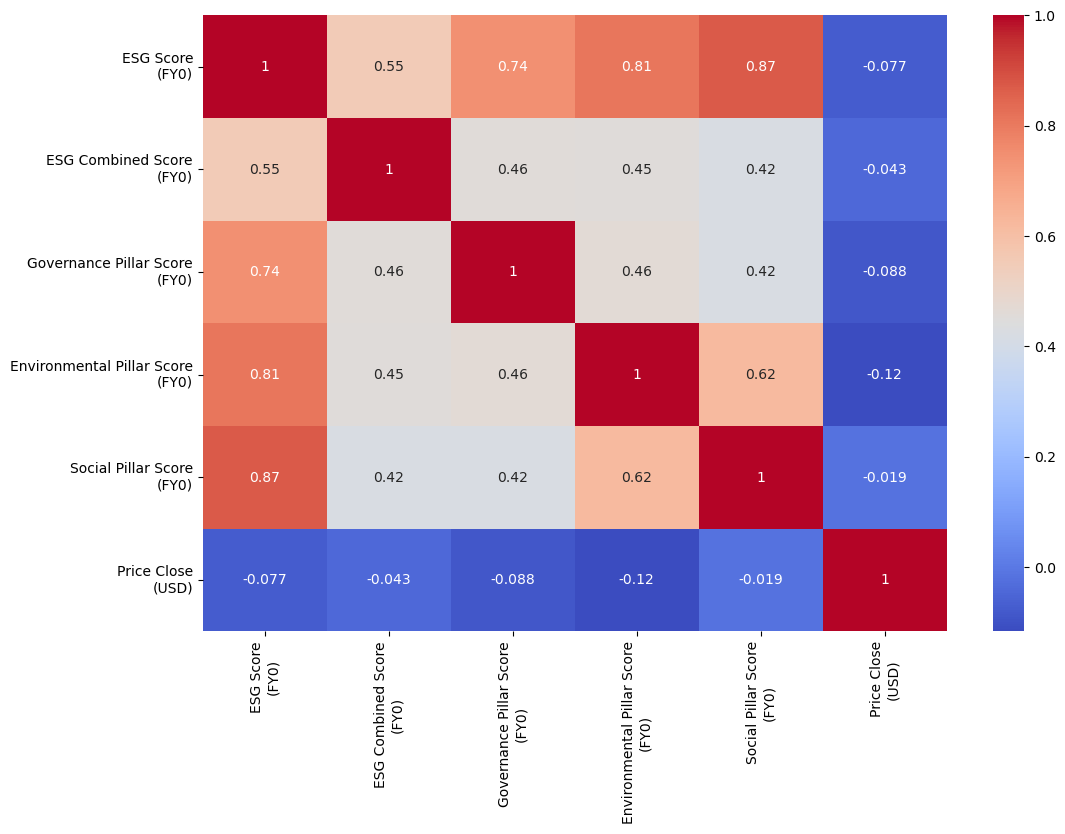

In [72]:
# Calculate the correlation between features and targets
correlation_matrix = X.join(y).corr()

# Visualize the Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [74]:
# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [78]:
# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

## 4-2 Random forest

In [81]:
# Model Training
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

RandomForestRegressor()

In [83]:
# Model prediction
y_pred = model.predict(X_test)

In [85]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 27.32
RMSE: 38.51
R²: -0.02


In [87]:
import matplotlib.pyplot as plt

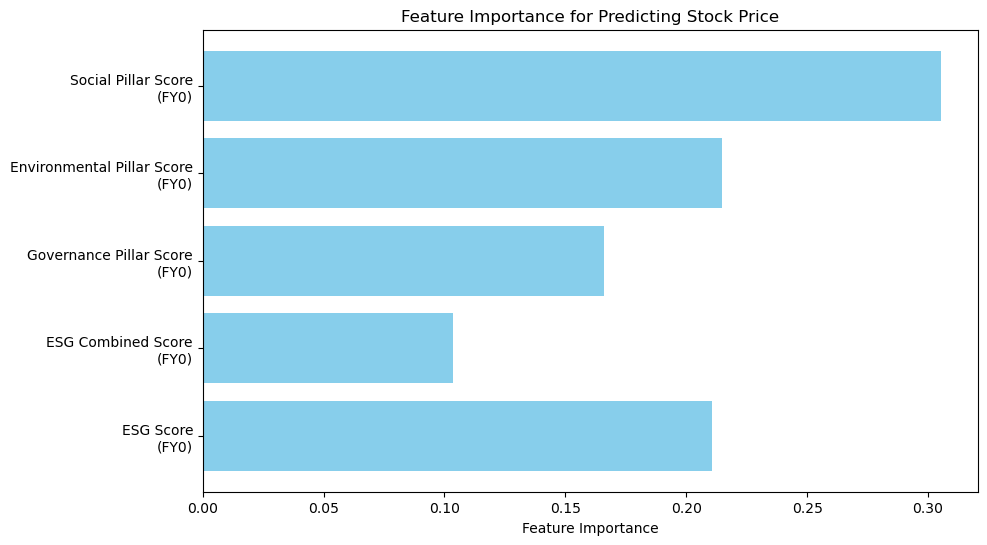

In [91]:
# Get feature importance
importances = model.feature_importances_
feature_names = features

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Predicting Stock Price")
plt.show()

# 5 Stock Price Prediction with LSTM

In [94]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [96]:
# Data loading
df = pd.read_excel('FTSE100 Data_ESG.xlsx', sheet_name='ftse100_daily_prices_updated')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [98]:
# Select the data of a single stock, taking JD.L as an example
ticker = 'JD.L' 
stock_data = df[df['Ticker'] == ticker][['Date', 'CLOSE']]

In [100]:
# Filling missing values
stock_data = stock_data.set_index('Date').resample('D').last().interpolate()

In [102]:
stock_data

CLOSE
Date                  
2014-01-02   14.650000
2014-01-03   14.940000
2014-01-04   15.026667
2014-01-05   15.113333
2014-01-06   15.200000
...                ...
2025-01-03   94.160000
2025-01-04   95.420000
2025-01-05   96.680000
2025-01-06   97.940000
2025-01-07  101.500000

[4024 rows x 1 columns]

In [104]:
# Extract features and normalize
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data['Scaled_Close'] = scaler.fit_transform(stock_data['CLOSE'].values.reshape(-1, 1))

In [106]:
stock_data['Scaled_Close']

Date
2014-01-02    0.004312
2014-01-03    0.005629
2014-01-04    0.006022
2014-01-05    0.006415
2014-01-06    0.006809
                ...   
2025-01-03    0.365229
2025-01-04    0.370949
2025-01-05    0.376668
2025-01-06    0.382388
2025-01-07    0.398547
Freq: D, Name: Scaled_Close, Length: 4024, dtype: float64

In [108]:
# Prepare training data and test data
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [110]:
# Extract training and test sets
train_size = int(len(stock_data) * 0.8)
train_data, test_data = stock_data.iloc[:train_size], stock_data.iloc[train_size:]

# Save the date related to the test set
dates_test_index = stock_data.index
seq_length = 60
dates_test = dates_test_index[train_size+seq_length+1:]

train_data = train_data[['Scaled_Close']].values
test_data = test_data[['Scaled_Close']].values

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [112]:
dates_test

DatetimeIndex(['2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31', '2023-01-01', '2023-01-02',
               '2023-01-03', '2023-01-04',
               ...
               '2024-12-29', '2024-12-30', '2024-12-31', '2025-01-01',
               '2025-01-02', '2025-01-03', '2025-01-04', '2025-01-05',
               '2025-01-06', '2025-01-07'],
              dtype='datetime64[ns]', name='Date', length=744, freq='D')

In [114]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [116]:
# Using LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

In [118]:
# Initialize the model
model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [120]:
# Training the model
epochs = 300
for epoch in range(epochs):
    model.train()
    
    y_train_pred = model(X_train)
    train_loss = criterion(y_train_pred, y_train.view(-1, 1))
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss.item():.4f}')

Epoch 1/300, Loss: 0.1537
Epoch 2/300, Loss: 0.1443
Epoch 3/300, Loss: 0.1354
Epoch 4/300, Loss: 0.1270
Epoch 5/300, Loss: 0.1191
Epoch 6/300, Loss: 0.1115
Epoch 7/300, Loss: 0.1044
Epoch 8/300, Loss: 0.0977
Epoch 9/300, Loss: 0.0914
Epoch 10/300, Loss: 0.0854
Epoch 11/300, Loss: 0.0799
Epoch 12/300, Loss: 0.0747
Epoch 13/300, Loss: 0.0698
Epoch 14/300, Loss: 0.0654
Epoch 15/300, Loss: 0.0614
Epoch 16/300, Loss: 0.0579
Epoch 17/300, Loss: 0.0548
Epoch 18/300, Loss: 0.0523
Epoch 19/300, Loss: 0.0504
Epoch 20/300, Loss: 0.0491
Epoch 21/300, Loss: 0.0485
Epoch 22/300, Loss: 0.0484
Epoch 23/300, Loss: 0.0487
Epoch 24/300, Loss: 0.0491
Epoch 25/300, Loss: 0.0494
Epoch 26/300, Loss: 0.0492
Epoch 27/300, Loss: 0.0486
Epoch 28/300, Loss: 0.0474
Epoch 29/300, Loss: 0.0460
Epoch 30/300, Loss: 0.0443
Epoch 31/300, Loss: 0.0427
Epoch 32/300, Loss: 0.0412
Epoch 33/300, Loss: 0.0398
Epoch 34/300, Loss: 0.0386
Epoch 35/300, Loss: 0.0375
Epoch 36/300, Loss: 0.0366
Epoch 37/300, Loss: 0.0356
Epoch 38/3

In [122]:
# Evaluating the Model
model.eval()
y_test_pred = model(X_test).detach().numpy()
y_test_real = y_test.numpy()

In [124]:
# Recover the predicted value and the true value to the original stock price
y_test_pred_original = scaler.inverse_transform(y_test_pred)
y_test_real_original = scaler.inverse_transform(y_test_real.reshape(-1, 1))

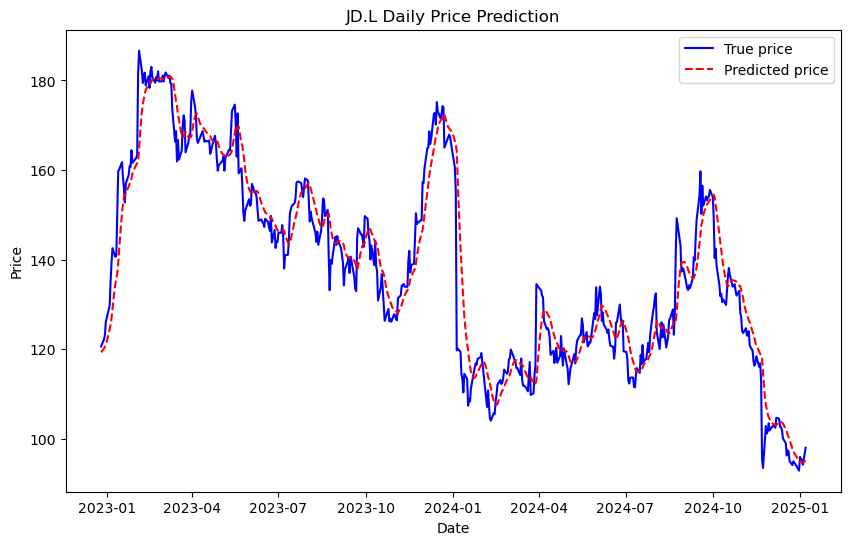

In [126]:
# Comparison curve
plt.figure(figsize=(10,6))
plt.plot(dates_test,y_test_real_original, label='True price', color='blue')
plt.plot(dates_test,y_test_pred_original, label='Predicted price', color='red', linestyle='--')
plt.title(f'{ticker} Daily Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [128]:
# Restore the normalized data to the original data
def inverse_transform(scaled_values, scaler):

    return scaler.inverse_transform(np.array(scaled_values).reshape(-1, 1)).flatten()

In [130]:
# Recursively predict future stock prices
def predict_future_prices(model, last_sequence, n_days=24):
    model.eval()
    predictions = []

    with torch.no_grad():
        current_input = torch.tensor(last_sequence, dtype=torch.float32)

        for _ in range(n_days):
            # Predict next day's price
            next_price = model(current_input)
            predictions.append(next_price.item())

            # Add the predicted value to the input sequence to predict the next day
            next_input = current_input[:, 1:, :].clone()
            current_input = torch.cat([next_input, next_price.unsqueeze(-1)], dim=1)

    return np.array(predictions)

In [132]:
# Example sequence length
sequence_length = 60

In [134]:
# Filter data named JD.L
data_jd = df[df['Ticker'] == 'JD.L'].sort_values('Date')
data_jd['Scaled_Close'] = scaler.fit_transform(data_jd['CLOSE'].values.reshape(-1, 1))
last_sequence = data_jd['Scaled_Close'].values[-sequence_length:].reshape(1, sequence_length, 1)

In [136]:
# Predict prices for the next 24 days
scaled_future_prices = predict_future_prices(model, last_sequence, n_days=24)

In [138]:
# Denormalize the prediction results
future_prices = inverse_transform(scaled_future_prices, scaler)

print(future_prices)

[96.75986331 96.83473572 96.89937259 96.94791754 96.98609564 97.01787899
 97.04572964 97.07118389 97.09517405 97.11827788 97.14086303 97.16313961
 97.18525205 97.20729227 97.22928653 97.25129393 97.27330132 97.29533498
 97.31740803 97.3395139  97.36163947 97.38381757 97.40602849 97.42827224]


In [140]:
# Predict every ticker
# The result will be in the third sheet of ‘FTSE100 Data_ESG.xlsx’
# Data loading
df = pd.read_excel('FTSE100 Data_ESG.xlsx', sheet_name='ftse100_daily_prices_updated')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Select the data of a single stock
ticker_list = df.iloc[:, 2].drop_duplicates()
future_prices = np.zeros([100,24])

ticker_number = 0
for ticker in ticker_list:
    stock_data = df[df['Ticker'] == ticker][['Date', 'CLOSE']]
    
    # Filling missing values
    stock_data = stock_data.set_index('Date').resample('D').last().interpolate()
    
    # Extract features and normalize
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data['Scaled_Close'] = scaler.fit_transform(stock_data['CLOSE'].values.reshape(-1, 1))
    
    # Extract training and test sets
    train_size = int(len(stock_data) * 0.8)
    train_data, test_data = stock_data.iloc[:train_size], stock_data.iloc[train_size:]

    # Save the date corresponding to the test set
    dates_test_index = stock_data.index
    dates_test = dates_test_index[train_size+seq_length+1:]

    train_data = train_data[['Scaled_Close']].values
    test_data = test_data[['Scaled_Close']].values

    X_train, y_train = create_dataset(train_data)
    X_test, y_test = create_dataset(test_data)
    
    # Convert to PyTorch tensor
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Initialize the model
    model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training the model
    epochs = 50
    for epoch in range(epochs):
        model.train()

        y_train_pred = model(X_train)
        train_loss = criterion(y_train_pred, y_train.view(-1, 1))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        #print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss.item():.4f}')

    # Evaluating the Model
    model.eval()
    y_test_pred = model(X_test).detach().numpy()
    y_test_real = y_test.numpy()
    
    # Recover the predicted value and the true value to the original stock price
    y_test_pred_original = scaler.inverse_transform(y_test_pred)
    y_test_real_original = scaler.inverse_transform(y_test_real.reshape(-1, 1))
    
    sequence_length = 60
    
    # Filter data
    data_jd = df[df['Ticker'] == ticker].sort_values('Date')
    data_jd['Scaled_Close'] = scaler.fit_transform(data_jd['CLOSE'].values.reshape(-1, 1))
    last_sequence = data_jd['Scaled_Close'].values[-sequence_length:].reshape(1, sequence_length, 1)
    
    # Predict prices for the next 24 days
    scaled_future_prices = predict_future_prices(model, last_sequence, n_days=24)
    future_price = inverse_transform(scaled_future_prices, scaler)
    
    future_prices[ticker_number] = future_price
    ticker_number += 1
    print(ticker_number)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [142]:
# Create Date Range
dates = pd.date_range(start='2025-01-08', end='2025-01-31').strftime('%Y-%m-%d').tolist()

# Create DataFrame
columns = ['Ticker'] + dates
data = pd.DataFrame(data={'Ticker': ticker_list}, columns=columns)
data.iloc[:, 1:] = future_prices

In [144]:
data.to_excel("FTSE100 Data_ESG.xlsx", sheet_name="FTSE100_daily_predict", index=False)